# L1 Computing the Proportion

To begin, we will focus on one of the fundamental building blocks: calculating the proportion. I chose to start with the proportion as (1) it is simple to understand, (2) it can be easily be computed by hand, and (3) it naturally builds up to more complex measures.

In words, the proportion is share of events for a well-defined group. Below is the formula for the proportion of $n$ individuals whose $Y_i = 1$

$$ \hat{\mu} = \frac{1}{n} \sum_i^n I(Y_i = 1)$$

The proportion in this context might be important to compute as it can be used to estimate the probability, $\mu$, for a population. To connect the estimand ($\mu$) and the estimate ($\hat{\mu}$), we adopt a large-sample framework, and make the following assumptions: the $n$ units are a random sample of the population (and are only a small percent of the total population), no measurement error of $Y$, and no missing values of $Y$. Under these assumptions, we can estimate the probability using the proportion formula above.

With these assumptions made, now the question becomes how can be compute $\hat{\mu}$. The rest of the tutorial focuses on this computational task. 

## 1.0 Setup

For this tutorial, we will use 3 free and open-source software (FOSS) libraries. These are `NumPy`, `SciPy`, and `matplotlib`. `NumPy` is used to basic numerical operations with arrays, `SciPy` will be used for some pre-built optimization functions, and `matplotlib` will be used to create plots.

In [1]:
import struct
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
print("Versions")
print("------------------")
print('NumPy     :', np.__version__)
print('SciPy     :', sp.__version__)
print('matplotlib:', matplotlib.__version__)

Versions
------------------
NumPy     : 1.25.2
SciPy     : 1.11.2
matplotlib: 3.5.1


For all the following examples, we will use the following data. The data consists of 60 observations with 20 events.

In [3]:
y_array = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                    1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                    1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                    1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## 1.1 Closed-form
First, we will consider the easiest and most computationally efficient way to compute the proportion: the closed-form. The formula for $\hat{\mu}$ above is a *closed-form* solution, in that we can directly compute the proportion from the number of events and number of observations. The proportion (i.e., estimator for the probability) is simply requires us to count up the number of events divided by the total number of units. 

To begin, we will manually compute the number of events and number of observations. While not the most efficient, we will use a `for` loop here to calculate. Specifically, we will keep count of the number of observations we have seen. Then we will also keep track of the number of events that occur. Below is code to accomplish this approach

In [4]:
def closed_form_byhand(y):
    total_n_obs = 0                             # Initialize number of observations as zero
    total_events = 0                            # Initialize number of events as zero

    for yi in y:                                # For loop through each Y_i value in the array
        total_n_obs = total_n_obs + 1           # ... add 1 to the number of observations counter
        if yi == 1:                             # ... if Y_i = 1 (i.e., is an event),
            total_events = total_events + 1     # ... then add 1 to the number of events counter

    # Closed-form formula with for-loop counts
    mu = total_events / total_n_obs
    return mu

In [5]:
mu_closedform = closed_form_byhand(y=y_array)

In [6]:
print(mu_closedform)

0.3333333333333333


While the code above works, it is slow (as it uses a `for` loop) and is a lot of code to complete such a basic task. Instead, let's use some built-in functionalities. We will use the `len` function to compute the number of observations and the `np.sum` function to count up the number of events (1's).

In [7]:
def closed_form_quick(y):
    event_obs = np.sum(y == 1)   # Number of events
    total_obs = len(y)           # Number of observations
    mu = event_obs / total_obs   # Closed-form formula
    return mu

In [8]:
mu_closedform = closed_form_quick(y=y_array)

In [9]:
print(mu_closedform)

0.3333333333333333


As we can see above, we end up with the same answer for both approaches. This is reassuring and highlights an important lesson: implementing equivalent computational procedures in different ways is a useful check. 

While the closed-form is computationally efficient and simple to implement for the proportion, closed-form solutions will not always be an option when we get to more complex problems. Therefore, we consider other ways we could compute the mean.

## 1.2 Maximization

Another option is to use maximum likelihood estimation. Briefly, the likelihood is the joint probability of the observed values of $Y$ given $\mu$. The likelihood is denoted as 

$$ \mathcal{L}(\mu | y)$$

where $y$ is a realization of the random variable $Y$. To estimate $\hat{\mu}$, we can find the value of $\mu$ that *maximizes* the likelihood give the observed data. Here, we have a binary event. As such, we will assume a Bernoulli distribution. The likelihood is therefore

$$ \mathcal{L}(\mu | y) = \prod_{i=1}^n \begin{pmatrix} n \\ y \end{pmatrix} \mu^{Y_i} \left(1 - \mu \right)^{1 - Y_i}$$

As the first term is a constant given the data, we can safely ignore it for our maximization procedure. Therefore, we we only need to maximize 

$$ \mathcal{L}(\mu | y) = \prod_{i=1}^n \mu^{Y_i} \left(1 - \mu \right)^{1 - Y_i}$$

However, this likelihood suffers from a computational issue. When multiplying numbers is harder for the computer than summing values. Therefore, we will maximize the *log-transformed* likelihood instead, which is a series of additions rather than multiplications. Importantly, the maximum of the log-likelihood is the same as the likelihood. 

The log-likelihood is

$$ \mathcal{l}(\mu | y) = \sum_{i=1}^n \left[Y_i \log(\mu) + \left(1 - Y_i\right) \log\left(1 - \mu \right) \right]$$

Using this equation, we can estimate the proportion by finding the value of $\hat{\mu}$ that maximizes this equation. In the machine learning world, we would call this function the *objective function*. Now we can consider how to find the parameter values that maximize this equation.

Before we do that, let's translate this equation into code.

In [10]:
def log_likelihood_individual(mu):
    # Array of individual contributions to log-likelihood
    return y_array*np.log(mu) + (1-y_array)*np.log(1-mu)

def log_likelihood_proportion(mu):
    logl_i = log_likelihood_individual(mu=mu)   # Individual contribution
    logl = np.sum(logl_i)                       # Log-likelihood
    return logl

Now the trick is determining how to maximize the log-likelihood. 

Some algorithms we will use instead *minimize* the objective function. As a result, we often need to instead *minimize* the *negative* log-likelihood, which is equivalent as maximizing the log-likelihood. The following function applies the negative transformation for us that we will use.

In [11]:
def neg_log_likelihood(mu):
    logl = log_likelihood_proportion(mu=mu)
    return -1*logl

Having set up everything, we can now consider different approaches to optimizing this function. 

### 1.2.1 Grid-Search

The simplest approach is to conduct a grid-search over the possible values of $\hat{\mu}$ and find which one gives us the smallest negative log-likelihood. 

Important to this approach is that we assume that $\hat{\mu}$ is between the starting values of our grid search. In the case of the proportion and starting our grid at $[0,1]$, we are reliably assume this.

The following bit of code implements a basic grid search. Note that our grid search has an error tolerance. One the scale of our grid goes below this threshold, we stop our procedure and return the best value of $\hat{\mu}$ our procedure found.

In [12]:
def grid_search_min(loglikelihood, tolerance):
    initial_grid = np.linspace(1e-15, 1-1e-15, num=12)
    current_grid_width = initial_grid[1] - initial_grid[0]

    # Conducting grid search until below tolerance
    while current_grid_width > tolerance:
        grid_evaluations = []
        for grid_value in initial_grid:
            eval_grid_logl = loglikelihood(mu=grid_value)
            grid_evaluations.append(eval_grid_logl)
            
        # Finding min evaluation
        min_index = np.argmin(grid_evaluations)  
        mu_first = initial_grid[min_index]

        # Finding second min evaluation
        del grid_evaluations[min_index]
        min2_index = np.argmin(grid_evaluations)  
        initial_grid = list(initial_grid)
        del initial_grid[min_index]
        mu_second = initial_grid[min2_index]
        
        # Creating new grid
        initial_grid = np.linspace(mu_first, mu_second, num=12)
        
        # Updating parameters
        current_grid_width = np.abs(initial_grid[1] - initial_grid[0])
    
    return mu_first

In [13]:
mu_grid = grid_search_min(loglikelihood=neg_log_likelihood, 
                          tolerance=1e-4)

In [14]:
print(mu_grid)

0.33358377160030084


As we can see, there is substantial error. That is because our approach is not *exact*. Instead we have a pre-specified error tolerance and our algorithm terminates once that threshold is met. To get a better approximation, we can lower the error tolerance level. The following applies a smaller tolerance.

In [15]:
mu_grid = grid_search_min(loglikelihood=neg_log_likelihood, 
                          tolerance=1e-12)

In [16]:
print(mu_grid)

0.33333333641661783


As seen, our answer is closer to 1/3. 

While a grid-search does work in this case, it is quite computationally intensive (as we have to consider whole grids of values) and doesn't easily generalize to settings with more than 1 parameter. Therefore, we consider more flexible alternatives.

### 1.2.2 Nelder-Mead

As the first alternative, we will use the Nelder-Mead algorithm. Here, we will use SciPy which provides Nelder-Mead and other maximization algorithms. These are implemented using very fast algorithms. Below illustrates how to apply this method

In [17]:
mu_nm = sp.optimize.minimize(neg_log_likelihood,    # Likelihood to minimize
                             x0=0.5,                # Starting values
                             method='Nelder-Mead',  # Method to use for min
                             tol=1e-9)              # Tolerance for covergence

In [18]:
print(mu_nm.x)

[0.33333334]


Here our answer is close to 1/3 again.

### 1.2.3 Monte Carlo

Monte Carlo procedures are an alternative option for finding the maximum (or minimum) of a function. However, they have distinct operations from the previous methods. These methods are also common in Bayesian estimation. Regardless, this approach still focuses on maximizing the log-likelihood.

Before we get to the code, let's go over an outline of Monte Carlo methods. Here, we are going to use a Metropolis sampling procedure. There are alternative mechanisms one can consider but Metropolis will work well here and is simple to implement. 

Essentially, we are going to take the parameter from the previous iteration and update it (using the candidate function defined above). Then we are going to evaluate the log-likelihood at the current parameter value and the proposed parameter value. Next, we calculate the probability of accepting the new proposed value. The probability of accepting the new value is based on the exponentiated difference in the log-likelihood. Finally, we resolve that probability to either keep the new value or the previous value. 

Because this is a probability, we will sometimes accept worse values, but this is okay for our purposes. As we will see, this allows the Monte Carlo to 'bounce' around values that are plausible for the likelihood. 

First, we will define a method to sample a new candidate value

In [19]:
def sampler_candidate(beta, rng):
    candidates = rng.normal(beta, scale=0.01)
    return candidates

The following function conducts a single iteration of our Metropolis sampler.

In [20]:
def metropolis_iteration(beta_init, rng):
    # Get initial value
    beta_prev = beta_init
    # Get a new candidate value
    beta_prop = sampler_candidate(beta=beta_prev, rng=rng)
    
    # Evaluate log-likelihood at both values
    logl_prev = log_likelihood_individual(mu=beta_prev)
    logl_prop = log_likelihood_individual(mu=beta_prop)

    # Compute the probability of accepting the candidate
    log_prob_accept = np.min([0, np.sum(logl_prop - logl_prev)])
    prob_accept = np.exp(log_prob_accept)
    
    # Flip a coin to determine whether the accept candidate
    accept = rng.binomial(n=1, p=prob_accept, size=1)
    
    # Resolve whether to accept candidate value
    if accept == 1:
        beta_prev = beta_prop
    else:
        pass
    
    # Return new value
    return beta_prev

Now we can wrap the function defined above to run the Metropolis sampler for a given number of iterations. We will save the values from each step (this is important for later!). It will be stored in a dictionary so we can easily pair the iteration number with the parameter value for that iteration.

In [21]:
def metropolis(init, m, prng):
    beta = init    # Setting the initial value
    chain = {}     # Dictionary to store chain
    
    # Call Monte-Carlo procedure a set number of time
    for i in range(m):
        beta = metropolis_iteration(beta_init=beta, rng=prng)
        chain[i] = beta
        
    # Return the full chain
    return chain

Unlike the previous procedures, this algorithm does not have an error-tolerance convergence condition. Instead, the user-specifies a maximum number of iterations and the process continues until that number is reached. To demonstrate this distinction, we will begin with a small number of iterations.

In [22]:
rng = np.random.RandomState(3992421)
c = metropolis(init=0.8, m=250, prng=rng)

(0.0, 1.0)

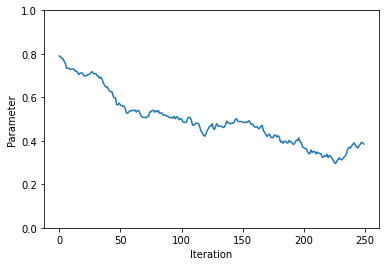

In [23]:
plt.plot(c.keys(), c.values(), '-')
plt.ylabel("Parameter")
plt.xlabel("Iteration")
plt.ylim([0, 1])

The above plot shows the current parameter value over the iteration. As we can see, the parameter wanders around a bit (or takes a 'random walk' around the parameter space). To explore the space and gravitate to the answer, we want to run a larger number of iterations.

Now, let's run the Monte Carlo procedure for a large number of iterations.

In [24]:
rng = np.random.RandomState(3992421)
c = metropolis(init=0.8, m=100000, prng=rng)

(0.0, 1.0)

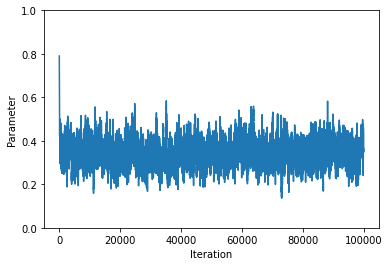

In [25]:
plt.plot(c.keys(), c.values(), '-')
plt.ylabel("Parameter")
plt.xlabel("Iteration")
plt.ylim([0, 1])

Here, we can see the space being explored. The parameter quickly leaves the starting value (0.8) as it fits poorly. Afterwards, we see the Monte Carlo procedure randomly jump around 0.3ish. 

To get our point estimate, we want to summarize these random walks as a single value. This can be done by calculating the mean or median of those values (ignore the circularity of needing to estimate the mean to get the proportion here). Generally, we drop the values at the start of the process since it needs to 'traverse' the space. Here, we will drop the first 1000 iterations.

In [26]:
param_iters = list(c.values())[999:]
print(np.median(param_iters))

0.3430506027472018


Here, we can see the point estimate is slightly different from the closed-form. This results from the simulation error. As the number of iterations $\rightarrow \infty$, the median or mean of the parameters should go to the closed form solution. 

### 1.2.4 Evolutionary algorithms

Another class of algorithms for maximization are *evolutionary algorithms*. These algorithms are inspired by the process of evolution or natural selection. Here, we are going to implement a simple evolutionary algorithm from scratch to compute the proportion. 

First, let's review some essential ideas for these types of algorithms. Our algorithm is going to start with a 'population' of individuals. This 'population' is going to contain some guesses for the mean. We are then going to evaluate each individual in terms of their 'fitness', where the fitness is the performance in terms of the objective function (i.e., the log-likelihood function in this case). Those individuals who have the greatest fitness are then used to produce the next generation. The reproduction cycle is repeated for a set amount of time.

To effectively search, we need the values of the inputs to change between generations. If the parents produce exact copies of themselves as children, we won't make any progress. So, we will introduce two types of variation in ou algorithm: genetic cross-over between parents and random point mutations. These allow children to vary from the parents. Therefore, we anticipate that children over successive generations will 'adapt' to finding the greatest fitness.

At this point, you might be wondering how this is applied computationally. Everything so far has been described under the guise of evolution. What does the genetic material of a 'number' look like? We will use the binary representation of numbers as their 'DNA'. Two functions are provided below which convert between floating point and binary representations.  

In [27]:
def convert_float_to_binary(value):
    [d] = struct.unpack(">Q", struct.pack(">d", value))
    return '{:064b}'.format(d)


def convert_binary_to_float(binary):
    bf = int(binary, 2).to_bytes(8, byteorder='big')
    return struct.unpack('>d', bf)[0]

In [28]:
b = convert_float_to_binary(1.3567)
b

'0011111111110101101101010000101100001111001001111011101100110000'

In [29]:
convert_binary_to_float(b)

1.3567

In the application of those functions, we can see how `1.3567` is stored as a series of 1's and 0's. That sequence of binary digits will be the 'DNA' of our number. It uniquely defines our number (in 64 bits). Different numbers of bits could also be used.

Now we can described cross-overs and point mutations. A cross-over occurs when we take two parents (two strings of binary digits) and create a child whose sequence consists of the first parent up to the $k$ digit and then is followed by the remainder of digits from the second parent. Below is a function that implements this to create both possible child combinations

In [30]:
def crossover(value_1, value_2, rng):
    # Random chance whether a cross-over occurs
    if rng.uniform(0, 1) < crossover_rate:
        # Selecting point where cross-over occurs
        crossover_loc = np.random.randint(1, len(value_1) - 2)
        ch_1 = value_1[:crossover_loc] + value_2[crossover_loc:]
        ch_2 = value_2[:crossover_loc] + value_1[crossover_loc:]
    # No cross-over otherwise
    else:
        ch_1 = parent_1
        ch_2 = parent_2
    return ch_1, ch_2

Point mutations simply flip 0 to 1 and 1 to 0 randomly. Below is a function to implement point mutations for a given mutation rate

In [31]:
def mutation(value, rng):
    value_list = list(value)
    for i in range(len(value_list)):
        if rng.uniform(0, 1) < mutation_rate:
            value_list[i] = str(1 - int(value_list[i]))
    return ''.join(value_list)

The final item we need is to decide how parents are selected. Below is a function the evaluates the parents and selects the best $m$ parents from that generation. These parents will be used to create the next generation.

In [32]:
def select_parents(objective_function, parents, parent_n):
    evaluated_i = objective_function(parents[:, None])
    evaluated = np.sum(evaluated_i, axis=1)

    evaluated_no_nan = evaluated[~np.isnan(evaluated)]
    parents_no_nan = parents[~np.isnan(evaluated)]
    best_of_gen = np.argpartition(evaluated_no_nan, -parent_n)[-parent_n:]

    parents_of_next_gen = parents_no_nan[best_of_gen]
    return parents_of_next_gen

Now that the basic elements of our evolutionary algorithm are defined, we can define a set of hyperparameters we will use. Each of these parameters is defined below

In [33]:
# Initial parameters
pop_size = 100          # Number of individuals in each generation
parent_n = 10           # Number of parents to generate next generation
crossover_rate = 0.5    # Probability of cross-over occurring
mutation_rate = 1 / 16  # Point mutation probability
generations = 100       # Number of generations to run

# Some starting values (slightly off the truth to showcase the algorithm)
starting_values = np.linspace(0.4, 0.95, pop_size)

# Creating a random number generation for consistency
rng = np.random.RandomState(8419812)

The following code implements our evolutionary algorithm. In each step of the for loop, we evaluate the current generation, select the most fit individuals, and produce offspring for the next generation. This continues for the set number of generations, like the Monte Carlo procedure. Unlike the Monte Carlo approach, the best individual in the final generation will be our point estimate of the proportion (instead of a median or mean across generations).

In [34]:
# Initial parents at the starting values
parents = starting_values

# Running the generations
for g in range(generations-1):
    # Evaluating and selecting parents
    next_gen_parents = select_parents(objective_function=log_likelihood_individual, 
                                      parents=parents,
                                      parent_n=parent_n)

    # Converting parents to their DNA sequences
    parent_dna = [convert_float_to_binary(v) for v in next_gen_parents]

    # Creating new DNA for children
    parent_pairs = rng.randint(0, parent_n, size=2*pop_size)  # Pairing parents
    children = []                                             # Storage for children
    for i in range(0, pop_size, 2):
        # Looking up parent pairs
        parent_1 = parent_dna[parent_pairs[i]]      # Getting DNA of first parent
        parent_2 = parent_dna[parent_pairs[i + 1]]  # Getting DNA of second parent
        
        # Cross-over
        child_1, child_2 = crossover(value_1=parent_1, 
                                     value_2=parent_2,
                                     rng=rng)

        # Random point mutations
        child_1 = mutation(child_1, rng=rng)
        child_2 = mutation(child_2, rng=rng)

        # Converting back to float
        children.append(convert_binary_to_float(child_1))
        children.append(convert_binary_to_float(child_2))
    
    # Setting children to be the next set of parents
    parents = np.asarray(children)


# Creating final generation of parents
final_parent = select_parents(objective_function=log_likelihood_individual, 
                              parents=parents,
                              parent_n=1)
# Selecting the best parent as the point estimate for the proportion
final_parent

C:\Users\zivic\AppData\Local\Temp\ipykernel_17460\3279974742.py:3: RuntimeWarning: invalid value encountered in log
  return y_array*np.log(mu) + (1-y_array)*np.log(1-mu)
C:\Users\zivic\AppData\Local\Temp\ipykernel_17460\3279974742.py:3: RuntimeWarning: invalid value encountered in subtract
  return y_array*np.log(mu) + (1-y_array)*np.log(1-mu)


array([0.33333333])

Our final estimate is `0.333`. However, note that it is slighly different from 1/3. Like the Monte Carlo method, this is because the algorithm is random and there is no defined stopping point. In the same way, we want to run our algorithm over many iterations to obtain a good solution. Better approximations to the proportion may be possible by (1) increasing the number of generations, (2) giving better starting values, (3) adapting the mutation or cross over rates, (4) changing the number of parents in each generation, or (5) increasing the population size in each generation. Try messing around with these hyperparameters yourself to see how performance changes.

In addition to these changes, there are many variations on how evolutionary algorithms can be implemented. These variations are not reviewed here (but the above algorithm could be adapted to these variations). One of note is the selection mechanism for parents. Here, we used a simple mechanism for selection of parents (the top $x$ performing parents). In complex settings, this selection approach might get stuck in local minima. This was not a concern in our application, as there is only a single maximum, but this might be a concern in other applications.

#### Further Reading

Katoch S, Chauhan SS, & Kumar V. (2021). A review on genetic algorithm: past, present, and future. *Multimedia tools and applications*, 80, 8091-8126.

## 1.4 Root-finding

Instead of minimizing (or maximizing), another option is to rewrite the original estimator as an equation equal to zero. Then we can search for the value of $\hat{\mu}$ that returns a zero. For this method, we first need our estimating equation. The estimating equation is a sum over all observations that is a function of the random variable, the parameter, and is equal to zero. The estimating equation for the proportion is
$$ \hat{\mu} = \frac{\sum_{i=1}^n I(Y_i = 1)}{n} $$
$$ n \hat{\mu} = \sum_{i=1}^n I(Y_i = 1) $$
$$ 0 = \sum_{i=1}^n I(Y_i = 1) - n \hat{\mu} $$
$$ 0 = \sum_{i=1}^n I(Y_i = 1) - \sum_{i=1}^n \hat{\mu} $$
$$ 0 = \sum_{i=1}^n \left[ I(Y_i = 1) - \hat{\mu} \right] $$
Therefore, we can find the proportion by finding the value of $\hat{\mu}$ that results in a zero for the above equation.

For ease, I will write the estimating equation as a generic function.

In [35]:
def estimating_equation(mu):
    evaluated_ee = 0
    for yi in y_array:
        contribution_i = yi - mu
        evaluated_ee = evaluated_ee + contribution_i
    return evaluated_ee

In general, algorithms to solve the previous equations are called *root-finding algorithms*, as the location of the zero point for a function is called its *root*. Here, we will consider a few options for root-finding algorithms. To start, we will start with a grid search approach.

### 1.4.1 Grid-Search

The simplest option for searching for the value of $\hat{\mu}$ that returns zero is to conduct a grid-search. This will be similar to the approach used for the minimization problem, but instead we will be looking for the point closest to zero. 

In [36]:
def root_grid(eequation, initial=[0, 1], tolerance=1e-9):
    # Setup
    left, right = initial[0], initial[1]
    mu_left = eequation(left)
    mu_right = eequation(right)
    error = 999
    
    # Simple grid-search
    while error > tolerance:
        center = (left + right) / 2    # Center
        mu_center = eequation(center)  # Function at center

        # Determining new cut-points
        if mu_center < 0:
            if left < 0:
                left = center
            else:
                right = center
        if mu_center >= 0:
            if left >= 0:
                left = center
            else:
                right = center

        # Computing updated error
        error = np.abs(mu_center)

    # Return parameter at the root
    return center

In [37]:
mu_root = root_grid(eequation=estimating_equation, initial=[0, 1])

In [38]:
print(mu_root)

0.3333333333430346


Important to this approach is that we assume that $\hat{\mu}$ is between the values. In the case of the proportion and starting our grid at $[0,1]$, we are reliably assume this. Another issue with a grid-search is that it is limited to a single parameter (okay for the proportion setting being considered). Finally, it requires computing the estimating equation for lots of different parameter values. 

To avoid these difficulties, we will take a brief tour through some other popular root-finding algorithms. For simplicity, we will use their SciPy implementations.

### 1.4.2 Levenberg-Marquardt

Here, we will use a built-in function from SciPy.

In [39]:
mu_root = sp.optimize.root(estimating_equation, 
                           x0=0.5, 
                           method='lm')

In [40]:
print(mu_root.x)

[0.33333333]


Root-finding has another important relationship to minimization algorithms. Rather than rewrite an equation, one could instead take the derivative of the function we are minimizing. The slope (derivative) at the minimum is zero. Therefore, root-finding is equivalent to minimization when functions have a single minimum.

## 1.5 Conclusions

This concludes the review of optimization procedures for the proportion. There are many other algorithms out there, but we saw that all these different approaches basically gave the same answer (or same answer within a given error tolerance). The basic principles reviewed here will get you many places and can be extended in multiple ways. If interested, consider going into the further reading.

The next lecture will consider ways to compute the variance for the proportion.